In [63]:
import yfinance as yf
import pandas as pd
from datetime import datetime

def download_and_save(ticker, period, interval, outname):
    """
    Télécharge des données via yfinance et sauvegarde en CSV.
    ticker   : symbole Yahoo (ex: 'EURUSD=X')
    period   : durée (ex: 'max', '5y', '60d')
    interval : fréquence (ex: '1d', '1h')
    outname  : nom du fichier de sortie (.csv)
    """
    print(f"[{datetime.now()}] Début téléchargement : {ticker} period={period} interval={interval}")
    try:
        df = yf.download(ticker, period=period, interval=interval)
    except Exception as e:
        print("Erreur réseau ou yfinance:", e)
        return False

    if df is None or df.empty:
        print("Aucune donnée récupérée pour", ticker, "(", period, interval, ")")
        return False

    # S'assurer que l'index est en datetime et trié
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    # Sauvegarde en CSV
    df.to_csv(outname)
    print(f"Terminé — fichier sauvegardé: {outname} (shape={df.shape})")
    return True

if __name__ == "__main__":
    # Paramètres : tu peux changer ici
    ticker = "EURUSD=X"
    # Daily (historique complet)
    download_and_save(ticker, period="max", interval="1d", outname="EURUSD_daily_yahoo.csv")




[2025-12-13 02:15:45.118224] Début téléchargement : EURUSD=X period=max interval=1d


[*********************100%***********************]  1 of 1 completed

Terminé — fichier sauvegardé: EURUSD_daily_yahoo.csv (shape=(5718, 5))


In [64]:
import pandas as pd
df = pd.read_csv("EURUSD_daily_yahoo.csv", index_col=0, parse_dates=True)
print(df.head())
print("Nombre de lignes :", len(df))


                         Close                High                 Low  \
Price                                                                    
Ticker                EURUSD=X            EURUSD=X            EURUSD=X   
Date                       NaN                 NaN                 NaN   
2003-12-01    1.19650137424469  1.2040069103240967   1.194400668144226   
2003-12-02  1.2088974714279175  1.2109030485153198  1.1946003437042236   
2003-12-03  1.2122975587844849   1.213003396987915  1.2077003717422485   

                          Open    Volume  
Price                                     
Ticker                EURUSD=X  EURUSD=X  
Date                       NaN       NaN  
2003-12-01    1.20339834690094         0  
2003-12-02  1.1961007118225098         0  
2003-12-03   1.208999752998352         0  
Nombre de lignes : 5720


In [65]:
# Recharger le fichier et corriger les colonnes
df = pd.read_csv("EURUSD_daily_yahoo.csv", header=[0,1], index_col=0, parse_dates=True)

# Fusionner les deux niveaux de colonnes et garder le nom principal (ex: 'Close')
df.columns = [col[0] for col in df.columns]

# Vérifier le résultat
print(df.head())
print("Colonnes disponibles :", df.columns.tolist())


               Close      High       Low      Open  Volume
Date                                                      
2003-12-01  1.196501  1.204007  1.194401  1.203398       0
2003-12-02  1.208897  1.210903  1.194600  1.196101       0
2003-12-03  1.212298  1.213003  1.207700  1.209000       0
2003-12-04  1.208094  1.214403  1.204398  1.212004       0
2003-12-05  1.218695  1.219096  1.206593  1.207802       0
Colonnes disponibles : ['Close', 'High', 'Low', 'Open', 'Volume']


In [66]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'].dropna())
print("ADF Statistic :", result[0])
print("p-value :", result[1])

if result[1] < 0.05:
    print("Série stationnaire (on rejette H0)")
else:
    print("Série non stationnaire (on ne rejette pas H0)")


ADF Statistic : -2.0790009686197415
p-value : 0.2530418122776551
Série non stationnaire (on ne rejette pas H0)


In [67]:
df['Close_diff'] = df['Close'].diff()


In [68]:
df = df.dropna()

In [69]:
result_diff = adfuller(df['Close_diff'])
print("ADF Statistic (diff) :", result_diff[0])
print("p-value (diff) :", result_diff[1])

if result_diff[1] < 0.05:
    print("Série différenciée stationnaire")
else:
    print("Toujours non stationnaire")


ADF Statistic (diff) : -13.798303664980299
p-value (diff) : 8.666170632203832e-26
Série différenciée stationnaire


In [70]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

# ML
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt

# 0) Charger données (pré-requis : avoir téléchargé le CSV)

df = pd.read_csv("EURUSD_daily_yahoo.csv", header=[0,1], index_col=0, parse_dates=True)
df.columns = [c[0] for c in df.columns]
df.sort_index(inplace=True)
df = df[["Open","High","Low","Close","Volume"]].copy()
print("Données chargées :", df.shape)


Données chargées : (5718, 5)


In [71]:
# 1) Feature engineering (différenciation + lags + MA + jour semaine)

def make_features(data):
    data = data.copy()
    data['Close_diff'] = data['Close'].diff()
    lags = [1,2,3,5,7,14]
    for lag in lags:
        data[f'lag_diff_{lag}'] = data['Close_diff'].shift(lag)
    windows = [3,7,14]
    for w in windows:
        data[f'ma_diff_{w}'] = data['Close_diff'].rolling(window=w).mean()
    for w in [7,14,30]:
        data[f'ma_price_{w}'] = data['Close'].rolling(window=w).mean()
    data['day_of_week'] = data.index.dayofweek
    data['target'] = data['Close_diff'].shift(-1)   # target = variation du jour suivant
    data = data.dropna()
    return data

df_feat = make_features(df)
print("Après feature engineering :", df_feat.shape)

Après feature engineering : (5688, 20)


In [72]:
# 2) Split chronologique train/val/test (70/15/15)

n = len(df_feat)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_df = df_feat.iloc[:train_end]
val_df   = df_feat.iloc[train_end:val_end]
test_df  = df_feat.iloc[val_end:]

# choisir colonnes de features (exclure target et colonnes intermédiaires inutiles)
exclude_cols = ["target", "Close_diff"]  # on prédit la diff
feature_cols = [c for c in df_feat.columns if c not in exclude_cols and c != "Close"]
# si tu veux inclure Close brut, décommente la ligne suivante :
# feature_cols.append("Close")

X_train, y_train = train_df[feature_cols], train_df["target"]
X_val,   y_val   = val_df[feature_cols],   val_df["target"]
X_test,  y_test  = test_df[feature_cols],  test_df["target"]

print("Taille train/val/test:", X_train.shape, X_val.shape, X_test.shape)


Taille train/val/test: (3981, 17) (853, 17) (854, 17)


In [42]:
# 3) Recherche d'hyperparamètres rapide (RandomizedSearchCV)

tscv_fast = TimeSeriesSplit(n_splits=3)

# Paramétrage RandomForest (petite grille)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10]
}
n_iter_rf = 12  

# Paramétrage XGBoost (petite grille)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0)
xgb_param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1]
}
n_iter_xgb = 9

print("Lancement RandomizedSearch (RF + XGB) .")
start_time = time.time()

rf_rand = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_dist,
    n_iter=n_iter_rf,
    cv=tscv_fast,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_rand.fit(X_train, y_train)
print("RF est le meilleur paramètre:", rf_rand.best_params_, "le meilleure score (neg MAE):", rf_rand.best_score_)

xgb_rand = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_param_dist,
    n_iter=n_iter_xgb,
    cv=tscv_fast,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_rand.fit(X_train, y_train)
print("XGB est le meilleur paramètre:", xgb_rand.best_params_, "le meilleure score (neg MAE):", xgb_rand.best_score_)



Lancement RandomizedSearch (RF + XGB) .
Fitting 3 folds for each of 12 candidates, totalling 36 fits
RF est le meilleur paramètre: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 5} le meilleure score (neg MAE): -0.006442561525241391
Fitting 3 folds for each of 9 candidates, totalling 27 fits
XGB est le meilleur paramètre: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01} le meilleure score (neg MAE): -0.0064343503001371176


In [43]:
# 4) Entraînement final sur (train + val) et évaluation sur test

def train_full_and_eval(best_estimator, X_tr, y_tr, X_v, y_v, X_t, y_t):
    X_full = pd.concat([X_tr, X_v], axis=0)
    y_full = pd.concat([y_tr, y_v], axis=0)
    best_estimator.fit(X_full, y_full)
    preds = best_estimator.predict(X_t)
    mae = mean_absolute_error(y_t, preds)
    rmse = np.sqrt(mean_squared_error(y_t, preds))
    return {"model": best_estimator, "preds": preds, "mae": mae, "rmse": rmse}

best_rf = rf_rand.best_estimator_
best_xgb = xgb_rand.best_estimator_

res_rf = train_full_and_eval(best_rf, X_train, y_train, X_val, y_val, X_test, y_test)
res_xgb = train_full_and_eval(best_xgb, X_train, y_train, X_val, y_val, X_test, y_test)

print("\n=== Résultats sur TEST ===")
print("RandomForest -> MAE:", res_rf["mae"], "RMSE:", res_rf["rmse"])
print("XGBoost      -> MAE:", res_xgb["mae"], "RMSE:", res_xgb["rmse"])

# Choix du meilleur selon MAE
if res_rf["mae"] <= res_xgb["mae"]:
    best_final = res_rf["model"]
    best_name = "RandomForest"
else:
    best_final = res_xgb["model"]
    best_name = "XGBoost"

print(f"\nModèle retenu: {best_name}")


=== Résultats sur TEST ===
RandomForest -> MAE: 0.0039017679771571204 RMSE: 0.005238748432074506
XGBoost      -> MAE: 0.00389968750544303 RMSE: 0.005237372889325484

Modèle retenu: XGBoost


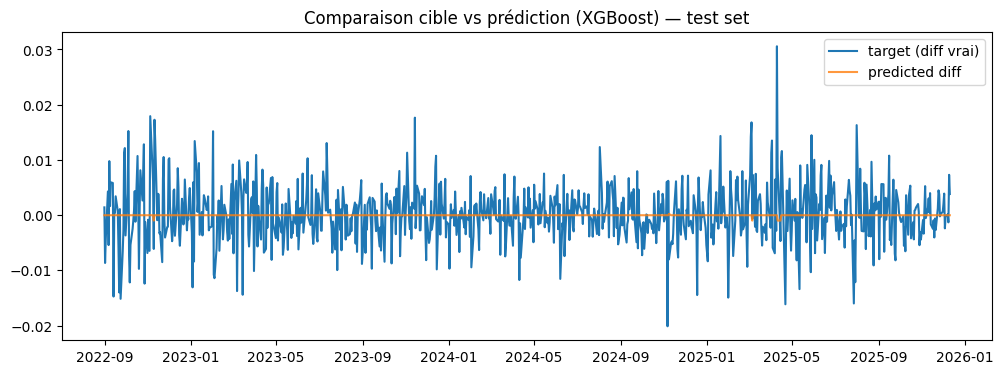

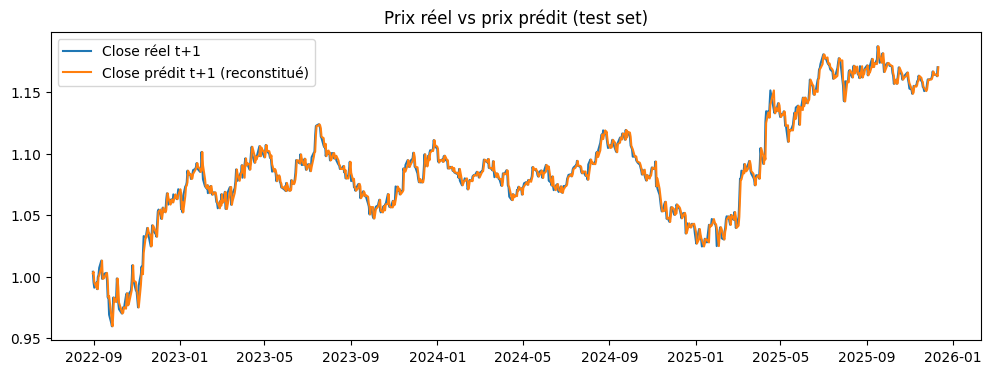

In [44]:
# 6) Visualisation simple (diff et reconstitution prix) sur test

preds = best_final.predict(X_test)
dates_test = X_test.index

plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test.values, label='target (diff vrai)')
plt.plot(dates_test, preds, label='predicted diff', alpha=0.8)
plt.title(f'Comparaison cible vs prédiction ({best_name}) — test set')
plt.legend()
plt.show()

# reconstruire prix prédit t+1
close_t = test_df.loc[dates_test, "Close"]
price_pred = close_t + preds
price_true_future = test_df.loc[dates_test, "Close"].shift(-1).loc[dates_test]
plt.figure(figsize=(12,4))
plt.plot(dates_test, price_true_future.values, label='Close réel t+1')
plt.plot(dates_test, price_pred, label='Close prédit t+1 (reconstitué)')
plt.title('Prix réel vs prix prédit (test set)')
plt.legend()
plt.show()

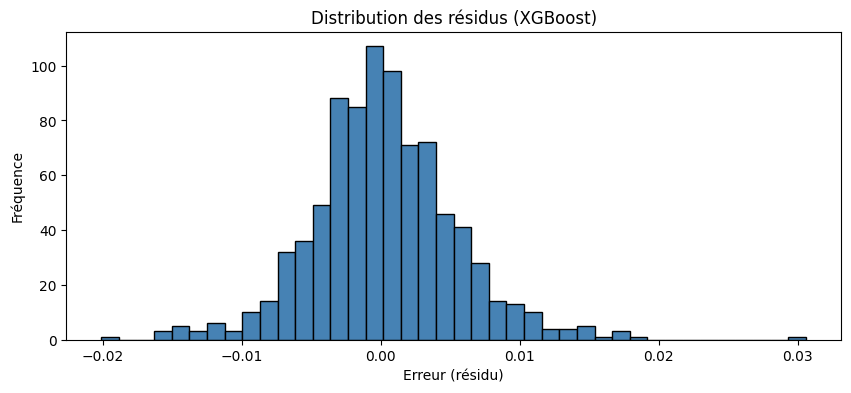


Nombre de pics détectés (|erreur| > 3σ) : 9
- 2022-11-04 : erreur = 0.017942
- 2022-11-10 : erreur = 0.017293
- 2023-11-14 : erreur = 0.017673
- 2024-11-06 : erreur = -0.020115
- 2025-03-05 : erreur = 0.016819
- 2025-04-10 : erreur = 0.030602
- 2025-04-22 : erreur = -0.016128
- 2025-07-28 : erreur = -0.015982
- 2025-08-01 : erreur = 0.016318


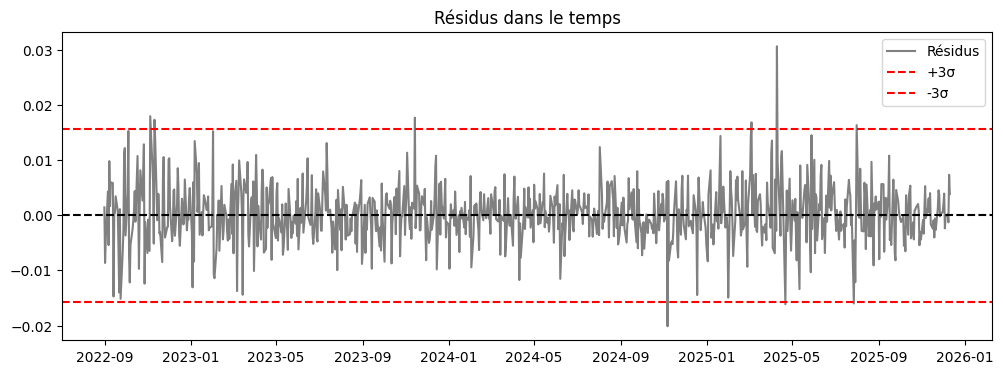

In [45]:
# 7) Analyse des résidus

residuals = y_test.values - preds  # erreurs (vrai - prédit)

# --- Histogramme des résidus ---
plt.figure(figsize=(10,4))
plt.hist(residuals, bins=40, color='steelblue', edgecolor='black')
plt.title(f"Distribution des résidus ({best_name})")
plt.xlabel("Erreur (résidu)")
plt.ylabel("Fréquence")
plt.show()

# --- Détection des pics d’erreur (outliers) ---
threshold = 3 * np.std(residuals)
outliers = np.where(np.abs(residuals) > threshold)[0]

print(f"\nNombre de pics détectés (|erreur| > 3σ) : {len(outliers)}")

# Afficher les dates et valeurs associées (si peu nombreuses)
if len(outliers) <= 10:
    for idx in outliers:
        date = dates_test[idx]
        print(f"- {date.date()} : erreur = {residuals[idx]:.6f}")
else:
    print(f"→ Trop de points à afficher ({len(outliers)}), tu peux les visualiser sur le graphique.")

# --- Visualisation temporelle des résidus ---
plt.figure(figsize=(12,4))
plt.plot(dates_test, residuals, label='Résidus', color='gray')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(threshold, color='red', linestyle='--', label='+3σ')
plt.axhline(-threshold, color='red', linestyle='--', label='-3σ')
plt.title("Résidus dans le temps")
plt.legend()
plt.show()


In [46]:

# 8) Score
# SCORE COMPOSITE (simple)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

preds = best_final.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

# Score entre 0 et 100 (plus c'est haut, mieux c'est)
score_composite = max(0, 100 - (mae * 1000 + rmse * 800))
print(f"Score composite du modèle : {score_composite:.2f}/100")



Score composite du modèle : 91.91/100


In [47]:
# SCORE DIRECTIONNEL
import numpy as np

true_sign = np.sign(y_test)
pred_sign = np.sign(best_final.predict(X_test))
directional_accuracy = np.mean(true_sign == pred_sign) * 100

print(f"Taux de direction correcte : {directional_accuracy:.2f} %")


Taux de direction correcte : 50.47 %


In [48]:
# 9) Modèle directionnel (classification : hausse/baisse)
# Bloc A : Imports nécessaires pour la partie classification
import numpy as np
import pandas as pd

# Validation temporelle et recherche d'hyperparamètres
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Métriques
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Modèles
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


In [49]:
# Bloc B : Construire la cible directionnelle (1 = hausse, 0 = baisse) et affichage

# Copier pour classification pour ne rien écraser
df_classif = df_feat.copy()

# Créer la cible binaire : 1 si la variation future (target) est positive (hausse), sinon 0
df_classif['target_dir'] = (df_classif['target'] > 0).astype(int)

# Afficher répartition et derniers exemples
print("\nRépartition de la cible directionnelle (value_counts) :")
print(df_classif['target_dir'].value_counts(normalize=True).map(lambda x: f"{x:.3f}").to_string())

print("\n5 dernières lignes de target et target_dir :")
print(df_classif[['target','target_dir']].tail())



Répartition de la cible directionnelle (value_counts) :
target_dir
0    0.503
1    0.497

5 dernières lignes de target et target_dir :
              target  target_dir
Date                            
2025-12-05 -0.000257           0
2025-12-08  0.000122           1
2025-12-09 -0.001313           0
2025-12-10  0.007293           1
2025-12-11  0.003819           1


In [50]:
# Bloc C : Split chronologique train/val/test pour la classification directionnelle
# mêmes proportions que pour la régression : 70% / 15% / 15%

# nombre total de lignes
n = len(df_classif)

# indices de coupure
train_end = int(n * 0.70)
val_end = int(n * 0.85)

# découpage chronologique (on garde l'ordre)
train_df = df_classif.iloc[:train_end]
val_df   = df_classif.iloc[train_end:val_end]
test_df  = df_classif.iloc[val_end:]

# colonnes de features (utiliser feature_cols déjà définies sinon recomposer)
try:
    feature_cols
except NameError:
    feature_cols = [c for c in df_feat.columns if c not in ["target","Close_diff","Close"]]

# X / y pour chaque split
X_train, y_train = train_df[feature_cols], train_df['target_dir']
X_val,   y_val   = val_df[feature_cols],   val_df['target_dir']
X_test,  y_test  = test_df[feature_cols],  test_df['target_dir']

# Affichages pour vérification
print("Taille (train / val / test) :",
      X_train.shape, X_val.shape, X_test.shape)

print("\nRépartition des classes dans chaque split (fraction de 1.0) :")
print(" Train :", y_train.value_counts(normalize=True).map(lambda x: f"{x:.3f}").to_dict())
print(" Val   :", y_val.value_counts(normalize=True).map(lambda x: f"{x:.3f}").to_dict())
print(" Test  :", y_test.value_counts(normalize=True).map(lambda x: f"{x:.3f}").to_dict())

# Afficher un aperçu (5 premières lignes) des X_train pour vérifier les colonnes
print("\nAperçu des features (X_train.head()) :")
display(X_train.head())


Taille (train / val / test) : (3981, 17) (853, 17) (854, 17)

Répartition des classes dans chaque split (fraction de 1.0) :
 Train : {0: '0.501', 1: '0.499'}
 Val   : {0: '0.508', 1: '0.492'}
 Test  : {0: '0.508', 1: '0.492'}

Aperçu des features (X_train.head()) :


,Open,High,Low,Volume,lag_diff_1,lag_diff_2,lag_diff_3,lag_diff_5,lag_diff_7,lag_diff_14,ma_diff_3,ma_diff_7,ma_diff_14,ma_price_7,ma_price_14,ma_price_30,day_of_week
Date,,,,,,,,,,,,,,,,,
2004-01-09,1.277498,1.286703,1.271294,0,0.013403,-0.008008,0.003405,0.000000,0.004108,0.001397,0.004597,0.003842,0.003286,1.269239,1.258590,1.240207,4
2004-01-12,1.284802,1.289707,1.273804,0,0.008394,0.013403,-0.008008,0.010504,-0.000808,0.000108,0.003334,0.002272,0.002435,1.271511,1.261025,1.242794,0
2004-01-13,1.274405,1.279705,1.271892,0,-0.011796,0.008394,0.013403,0.003405,0.000000,0.005296,0.000365,0.002914,0.002378,1.274425,1.263403,1.245117,1
2004-01-14,1.278805,1.278805,1.240602,0,0.004496,-0.011796,0.008394,-0.008008,0.010504,-0.000496,-0.006930,-0.000514,0.001450,1.273911,1.264853,1.246877,2
2004-01-15,1.265599,1.267106,1.256897,0,-0.013490,0.004496,-0.011796,0.013403,0.003405,-0.001609,-0.004667,-0.001715,0.001207,1.272196,1.266061,1.248611,3


In [85]:
# BLOC D — Importer les modèles et préparer la recherche aléatoire
# PARTIE D1 — Définir modèles + recherche de paramètres

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import time
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # Assurez-vous d'avoir les imports si vous exécutez séparément

# --- Validation croisée adaptée aux séries temporelles ---
tscv = TimeSeriesSplit(n_splits=3)

# --- RandomForestClassifier ---
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10]
}

# --- XGBClassifier ---
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)
xgb_param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1]
}
# ----------------------------------------------------------------------
# --- Régression Logistique (LogisticRegression) ---
# ----------------------------------------------------------------------

logreg_clf = LogisticRegression(random_state=42, max_iter=500, n_jobs=-1) 
# Note : n_jobs=-1 n'est supporté que par le 'solver'='liblinear' pour la Régression Logistique

# Nous utilisons une grille de paramètres plus complète pour LogReg
logreg_param_dist = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100], 
    "penalty": ['l2'], 
    "solver": ['lbfgs', 'liblinear'] # lbfgs est le solveur par défaut et est souvent le meilleur
}

# Création de l'objet de recherche pour la Régression Logistique (Utilisation de GridSearchCV ici car la grille est petite)
# Si vous voulez absolument utiliser RandomizedSearchCV, le code ci-dessous est adapté,
# mais GridSearchCV est souvent préféré pour les modèles simples.

logreg_search = GridSearchCV( # Vous pouvez remplacer par RandomizedSearchCV si vous voulez
    estimator=logreg_clf,
    param_grid=logreg_param_dist,
    scoring='accuracy',
    cv=tscv, # Utilisation du TimeSeriesSplit
    verbose=0,
    n_jobs=-1
)

# --- Exécution des recherches (Ajoutez ceci au bas du BLOC E si vous le souhaitez) ---

# # Entraînement des deux modèles sur l'ensemble complet (X_train_val et y_train_val doivent être définis)
# X_full = pd.concat([X_train, X_val])
# y_full = pd.concat([y_train, y_val])
# 
# start_time = time.time()
# logreg_search.fit(X_full, y_full)
# end_time = time.time()
# 
# print(f"Temps d'exécution LogReg Search: {end_time - start_time:.2f} secondes")
# best_logreg = logreg_search.best_estimator_

In [ ]:
# PARTIE D2 — Lancer la recherche aléatoire (RF + XGB)

rf_search = RandomizedSearchCV(
    rf_clf,
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_search.fit(X_train, y_train)

xgb_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=xgb_param_dist,
    n_iter=8,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_search.fit(X_train, y_train)


print("\n=== Résultats des recherches ===")
print("RandomForest — meilleurs paramètres :", rf_search.best_params_, " | score :", rf_search.best_score_)
print("XGBoost       — meilleurs paramètres :", xgb_search.best_params_, " | score :", xgb_search.best_score_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits

=== Résultats des recherches ===
RandomForest — meilleurs paramètres : {'n_estimators': 50, 'min_samples_split': 10, 'max_depth': None}  | score : 0.510217755443886
XGBoost       — meilleurs paramètres : {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}  | score : 0.507537688442211


In [53]:
# BLOC E — Entraînement final + évaluation sur test


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# -Sélection des meilleurs modèles selon la recherche précédente ---
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# -Fusion train + val pour un apprentissage complet ---
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

# -Entraînement des deux modèles sur l'ensemble complet ---
best_rf.fit(X_full, y_full)
best_xgb.fit(X_full, y_full)

# -Évaluation sur le jeu de test ---
pred_rf = best_rf.predict(X_test)
pred_xgb = best_xgb.predict(X_test)

acc_rf = accuracy_score(y_test, pred_rf)
acc_xgb = accuracy_score(y_test, pred_xgb)

print("\n=== Résultats sur TEST ===")
print(f"RandomForest -> Accuracy : {acc_rf:.4f}")
print(f"XGBoost      -> Accuracy : {acc_xgb:.4f}")

# -Rapport détaillé ---
print("\nRapport XGBoost :")
print(classification_report(y_test, pred_xgb, target_names=['Baisse (0)', 'Hausse (1)']))

# -Matrice de confusion (pour visualiser les bonnes / mauvaises prédictions) ---
cm = confusion_matrix(y_test, pred_xgb)
print("\nMatrice de confusion (XGBoost) :\n", cm)



=== Résultats sur TEST ===
RandomForest -> Accuracy : 0.5492
XGBoost      -> Accuracy : 0.5468

Rapport XGBoost :
              precision    recall  f1-score   support

  Baisse (0)       0.55      0.62      0.58       434
  Hausse (1)       0.55      0.47      0.50       420

    accuracy                           0.55       854
   macro avg       0.55      0.55      0.54       854
weighted avg       0.55      0.55      0.54       854


Matrice de confusion (XGBoost) :
 [[271 163]
 [224 196]]


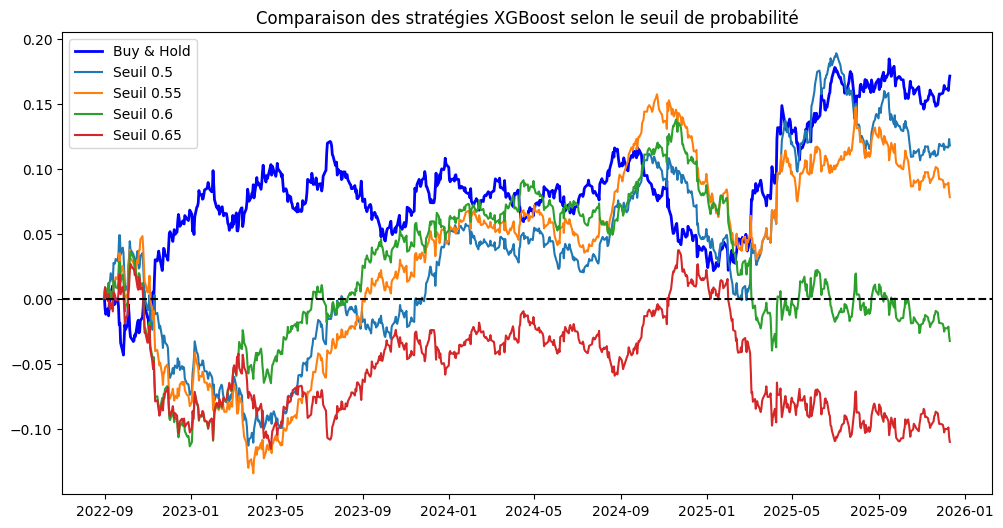

In [54]:
# BLOC F : Visualiser les courbes cumulées pour différents seuils

import numpy as np
import matplotlib.pyplot as plt

# Probabilités prédites par XGBoost
proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Seuils à tester
thresholds = [0.5, 0.55, 0.6, 0.65]

plt.figure(figsize=(12,6))

# Rendements réels
real_returns = df_feat.loc[X_test.index, 'target'].values
cumulative_real = np.cumsum(real_returns)
plt.plot(X_test.index, cumulative_real, label="Buy & Hold", color="blue", linewidth=2)

# Boucle sur les seuils
for thr in thresholds:
    preds_thr = (proba_xgb > thr).astype(int)
    
    # Stratégie : long si 1, short si 0
    strategy_returns = np.where(preds_thr == 1, real_returns, -real_returns)
    
    # Frais de transaction (0.1% par changement de position)
    fee_rate = 0.001
    signal_changes = np.diff(preds_thr, prepend=preds_thr[0]) != 0
    fees = signal_changes.astype(int) * fee_rate
    strategy_returns -= fees
    
    # Rendement cumulé
    cumulative_strategy = np.cumsum(strategy_returns)
    
    plt.plot(X_test.index, cumulative_strategy, label=f"Seuil {thr}")

plt.axhline(0, color="black", linestyle="--")
plt.title("Comparaison des stratégies XGBoost selon le seuil de probabilité")
plt.legend()
plt.show()


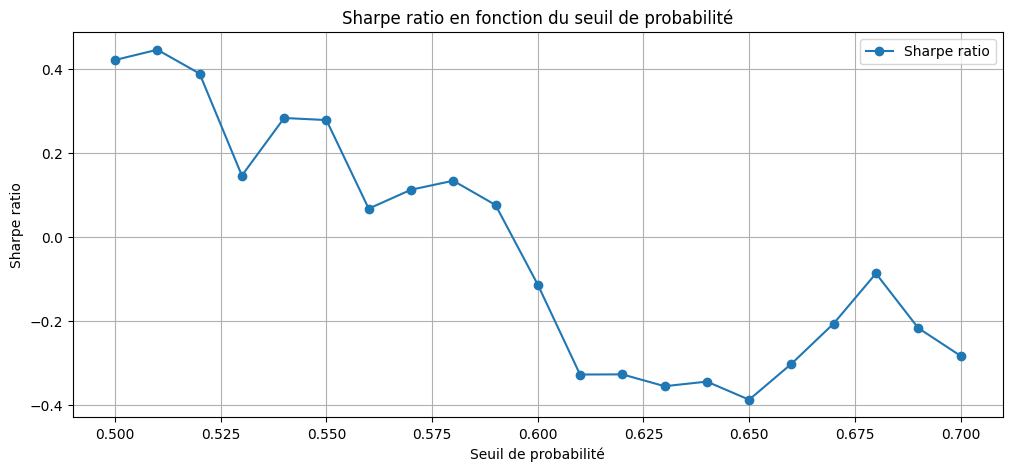

Seuil optimal : 0.51
Sharpe max : 0.45
Perf cumulée : 0.125
Max Drawdown : -0.155


In [55]:
# BLOC G : Balayer les seuils de 0.50 à 0.70 et tracer le Sharpe ratio

import numpy as np
import matplotlib.pyplot as plt

# Probabilités prédites par XGBoost
proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Rendements réels alignés avec X_test
real_returns = df_feat.loc[X_test.index, 'target'].values

thresholds = np.arange(0.50, 0.71, 0.01)
sharpes = []
performances = []
drawdowns = []

for thr in thresholds:
    preds_thr = (proba_xgb > thr).astype(int)
    
    # Stratégie : long si 1, short si 0
    strategy_returns = np.where(preds_thr == 1, real_returns, -real_returns)
    
    # Frais de transaction (0.1% par changement de position)
    fee_rate = 0.001
    signal_changes = np.diff(preds_thr, prepend=preds_thr[0]) != 0
    fees = signal_changes.astype(int) * fee_rate
    strategy_returns -= fees
    
    # Perf cumulée
    cum_perf = np.cumsum(strategy_returns)[-1]
    performances.append(cum_perf)
    
    # Sharpe ratio
    mean_ret = np.mean(strategy_returns)
    std_ret = np.std(strategy_returns)
    sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret > 0 else np.nan
    sharpes.append(sharpe)
    
    # Max drawdown
    cum_curve = np.cumsum(strategy_returns)
    rolling_max = np.maximum.accumulate(cum_curve)
    drawdowns.append((cum_curve - rolling_max).min())

# --- Visualisation ---
plt.figure(figsize=(12,5))
plt.plot(thresholds, sharpes, marker='o', label="Sharpe ratio")
plt.title("Sharpe ratio en fonction du seuil de probabilité")
plt.xlabel("Seuil de probabilité")
plt.ylabel("Sharpe ratio")
plt.grid(True)
plt.legend()
plt.show()

# Résumé du meilleur seuil
best_idx = np.nanargmax(sharpes)
print(f"Seuil optimal : {thresholds[best_idx]:.2f}")
print(f"Sharpe max : {sharpes[best_idx]:.2f}")
print(f"Perf cumulée : {performances[best_idx]:.3f}")
print(f"Max Drawdown : {drawdowns[best_idx]:.3f}")


=== Évaluation avec seuil optimal ===
Accuracy : 0.5304
              precision    recall  f1-score   support

  Baisse (0)       0.52      0.85      0.65       434
  Hausse (1)       0.56      0.20      0.30       420

    accuracy                           0.53       854
   macro avg       0.54      0.53      0.47       854
weighted avg       0.54      0.53      0.48       854

Matrice de confusion :
 [[368  66]
 [335  85]]


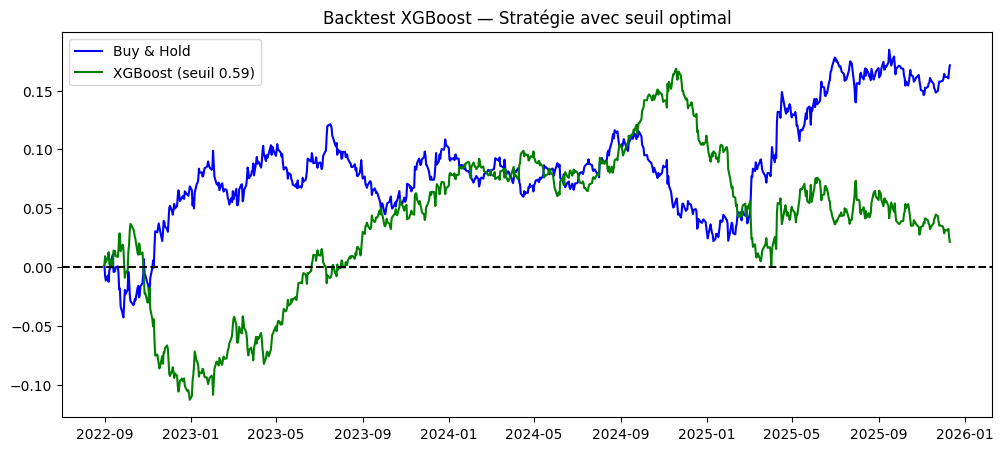


=== Résultats finaux ===
Performance Buy & Hold : 0.17143690586090088
Performance Stratégie XGBoost (seuil 0.59) : 0.021306290626525004
Sharpe ratio : 0.07571284896810802
Max Drawdown : -0.16737958335876557


In [56]:
# 10) Stratégie XGBoost avec seuil optimal (0.59)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -Reprendre le meilleur modèle XGBoost trouvé
best_xgb = xgb_search.best_estimator_

# -Réentraîner sur l'ensemble train + val
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])
best_xgb.fit(X_full, y_full)

# -Prédictions probabilistes sur le test
proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# -Application du seuil optimal
threshold = 0.59
pred_xgb_opt = (proba_xgb > threshold).astype(int)

# -Évaluation classique
acc = accuracy_score(y_test, pred_xgb_opt)
print("=== Évaluation avec seuil optimal ===")
print(f"Accuracy : {acc:.4f}")
print(classification_report(y_test, pred_xgb_opt, target_names=['Baisse (0)', 'Hausse (1)']))
print("Matrice de confusion :\n", confusion_matrix(y_test, pred_xgb_opt))

# -Backtest directionnel avec seuil optimal
real_returns = df_feat.loc[X_test.index, 'target'].values
strategy_returns = np.where(pred_xgb_opt == 1, real_returns, -real_returns)

# Frais de transaction (0.1% par changement de position)
fee_rate = 0.001
signal_changes = np.diff(pred_xgb_opt, prepend=pred_xgb_opt[0]) != 0
fees = signal_changes.astype(int) * fee_rate
strategy_returns -= fees

# Rendements cumulés
cumulative_real = np.cumsum(real_returns)
cumulative_strategy = np.cumsum(strategy_returns)

# Sharpe ratio
mean_ret = np.mean(strategy_returns)
std_ret = np.std(strategy_returns)
sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret > 0 else np.nan

# Max drawdown
rolling_max = np.maximum.accumulate(cumulative_strategy)
drawdowns = cumulative_strategy - rolling_max
max_dd = drawdowns.min()

# - Visualisation
plt.figure(figsize=(12,5))
plt.plot(X_test.index, cumulative_real, label="Buy & Hold", color="blue")
plt.plot(X_test.index, cumulative_strategy, label=f"XGBoost (seuil {threshold})", color="green")
plt.axhline(0, color="black", linestyle="--")
plt.title("Backtest XGBoost — Stratégie avec seuil optimal")
plt.legend()
plt.show()

# - Résultats finaux
print("\n=== Résultats finaux ===")
print("Performance Buy & Hold :", cumulative_real[-1])
print(f"Performance Stratégie XGBoost (seuil {threshold}) :", cumulative_strategy[-1])
print("Sharpe ratio :", sharpe)
print("Max Drawdown :", max_dd)


In [57]:
accuracy = accuracy_score(y_test, best_xgb.predict(X_test))
cumulative_perf = np.sum(strategy_returns)
sharpe = (np.mean(strategy_returns) / np.std(strategy_returns)) * np.sqrt(252)

score_composite = (accuracy * 50) + (min(sharpe, 2) / 2 * 30) + (max(0, cumulative_perf) * 20)
score_composite = min(score_composite, 100)

print(f"Score composite final : {score_composite:.2f}/100")


Score composite final : 28.90/100


In [58]:
# 11) Sauvegarde avec seuil optimal
import joblib

artifact = {
    "model": best_xgb,               
    "feature_columns": feature_cols,
    "threshold": 0.59                
}

joblib.dump(artifact, "model_final_bourse_xgboost.joblib")
print(" Modèle sauvegardé avec seuil optimal (0.59) sous : model_final_bourse_xgboost.joblib")

 Modèle sauvegardé avec seuil optimal (0.59) sous : model_final_bourse_xgboost.joblib


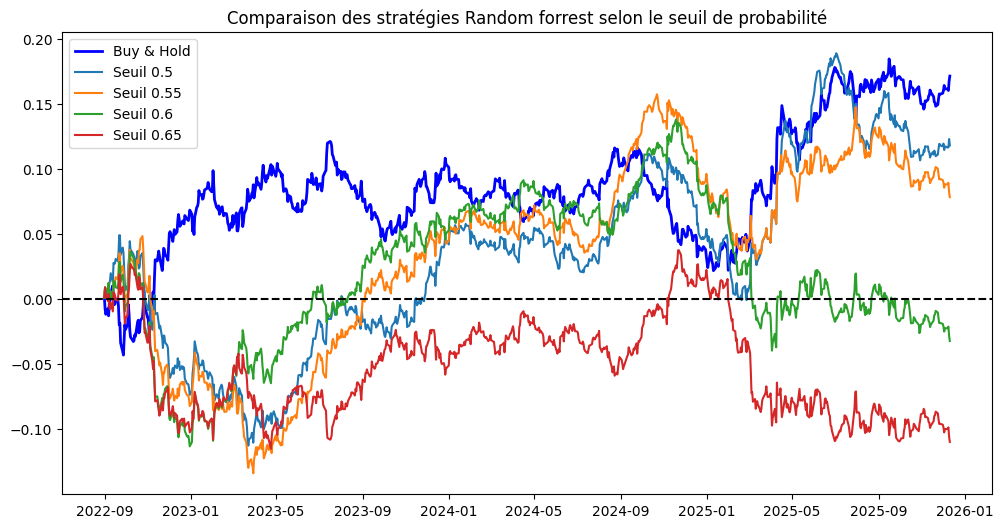

In [59]:
# BLOC F : Visualiser les courbes cumulées pour différents seuils

import numpy as np
import matplotlib.pyplot as plt

# Probabilités prédites par XGBoost
proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Seuils à tester
thresholds = [0.5, 0.55, 0.6, 0.65]

plt.figure(figsize=(12,6))

# Rendements réels
real_returns = df_feat.loc[X_test.index, 'target'].values
cumulative_real = np.cumsum(real_returns)
plt.plot(X_test.index, cumulative_real, label="Buy & Hold", color="blue", linewidth=2)

# Boucle sur les seuils
for thr in thresholds:
    preds_thr = (proba_xgb > thr).astype(int)
    
    # Stratégie : long si 1, short si 0
    strategy_returns = np.where(preds_thr == 1, real_returns, -real_returns)
    
    # Frais de transaction (0.1% par changement de position)
    fee_rate = 0.001
    signal_changes = np.diff(preds_thr, prepend=preds_thr[0]) != 0
    fees = signal_changes.astype(int) * fee_rate
    strategy_returns -= fees
    
    # Rendement cumulé
    cumulative_strategy = np.cumsum(strategy_returns)
    
    plt.plot(X_test.index, cumulative_strategy, label=f"Seuil {thr}")

plt.axhline(0, color="black", linestyle="--")
plt.title("Comparaison des stratégies Random forrest selon le seuil de probabilité")
plt.legend()
plt.show()


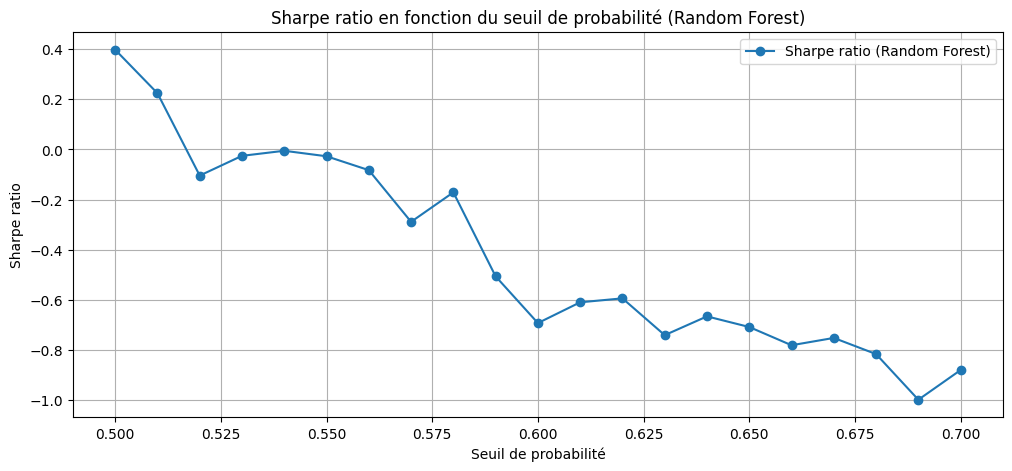

--- Résumé du Seuil Optimal pour Random Forest (max Sharpe) ---
Seuil optimal : 0.50
Sharpe max : 0.40
Perf cumulée : 0.112
Max Drawdown (valeur) : -0.072
Max Drawdown (%) : -6.94%


In [60]:
# BLOC G : Balayer les seuils de 0.50 à 0.70 et tracer le Sharpe ratio pour Random Forest

import numpy as np
import matplotlib.pyplot as plt

# --- ASSUMPTION: 'best_rf' and 'X_test' are defined and 'proba_rf' is calculated as follows ---
# Si 'proba_rf' n'est pas déjà défini à partir du bloc précédent, le décommenter :
# proba_rf = best_rf.predict_proba(X_test)[:, 1] 
# ---------------------------------------------------------------------------------------------

# Probabilités prédites par Random Forest (utiliser 'proba_rf' au lieu de 'proba_xgb')
proba_model = proba_rf # On utilise les probabilités de Random Forest

# Rendements réels alignés avec X_test
# Assurez-vous que 'df_feat' est accessible et que 'X_test.index' est correct
real_returns = df_feat.loc[X_test.index, 'target'].values 

# Définition des seuils
thresholds = np.arange(0.50, 0.71, 0.01)
sharpes = []
performances = []
drawdowns = []
max_drawdowns_percent = [] # Pour stocker le drawdown max en % de la courbe

for thr in thresholds:
    # Utilisation des probabilités du modèle RF
    preds_thr = (proba_model > thr).astype(int) 
    
    # Stratégie : long si 1, short si 0
    strategy_returns = np.where(preds_thr == 1, real_returns, -real_returns)
    
    # Frais de transaction (0.1% par changement de position)
    fee_rate = 0.001
    # Détection des changements de position (signal_changes est True si la position change)
    signal_changes = np.diff(preds_thr, prepend=preds_thr[0]) != 0
    fees = signal_changes.astype(int) * fee_rate
    strategy_returns -= fees
    
    # Perf cumulée
    cum_perf = np.cumsum(strategy_returns)[-1]
    performances.append(cum_perf)
    
    # Sharpe ratio
    mean_ret = np.mean(strategy_returns)
    std_ret = np.std(strategy_returns)
    # Annualisation (np.sqrt(252) pour des rendements quotidiens)
    sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret > 0 else np.nan
    sharpes.append(sharpe)
    
    # Max drawdown
    cum_curve = np.cumsum(strategy_returns)
    rolling_max = np.maximum.accumulate(cum_curve)
    
    # Drawdown en valeur absolue
    drawdown_abs = (cum_curve - rolling_max) 
    drawdown_val_max = drawdown_abs.min()
    drawdowns.append(drawdown_val_max)
    
    # Drawdown en pourcentage (utile pour l'interprétation)
    # Le drawdown max en % est (valeur min - valeur max) / valeur max
    # On utilise np.exp(cum_curve) pour travailler sur des prix/valeurs
    equity_curve = np.exp(cum_curve) 
    rolling_max_equity = np.maximum.accumulate(equity_curve)
    drawdown_percent = ((equity_curve - rolling_max_equity) / rolling_max_equity).min()
    max_drawdowns_percent.append(drawdown_percent)


# --- Visualisation ---
plt.figure(figsize=(12,5))
plt.plot(thresholds, sharpes, marker='o', label="Sharpe ratio (Random Forest)")
plt.title("Sharpe ratio en fonction du seuil de probabilité (Random Forest)")
plt.xlabel("Seuil de probabilité")
plt.ylabel("Sharpe ratio")
plt.grid(True)
plt.legend()
plt.show()

# Résumé du meilleur seuil
best_idx = np.nanargmax(sharpes)
best_thr = thresholds[best_idx]

print(f"--- Résumé du Seuil Optimal pour Random Forest (max Sharpe) ---")
print(f"Seuil optimal : {best_thr:.2f}")
print(f"Sharpe max : {sharpes[best_idx]:.2f}")
print(f"Perf cumulée : {performances[best_idx]:.3f}")
print(f"Max Drawdown (valeur) : {drawdowns[best_idx]:.3f}")
print(f"Max Drawdown (%) : {max_drawdowns_percent[best_idx]*100:.2f}%")

=== Évaluation Random Forest avec seuil optimal (0.50) ===
Accuracy : 0.5492
              precision    recall  f1-score   support

  Baisse (0)       0.55      0.58      0.57       434
  Hausse (1)       0.54      0.52      0.53       420

    accuracy                           0.55       854
   macro avg       0.55      0.55      0.55       854
weighted avg       0.55      0.55      0.55       854

Matrice de confusion :
 [[252 182]
 [203 217]]


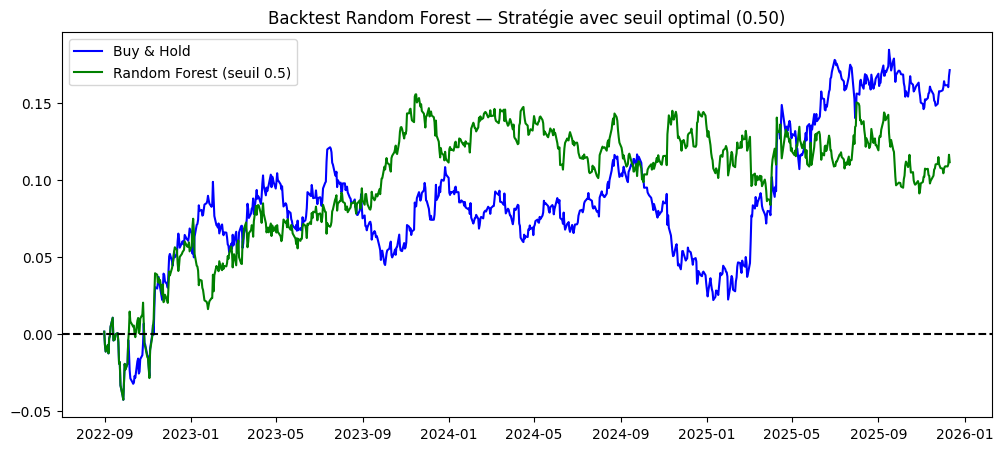


=== Résultats finaux Random Forest ===
Performance Buy & Hold : 0.17143690586090088
Performance Stratégie Random Forest (seuil 0.5) : 0.1116
Sharpe ratio : 0.3971
Max Drawdown : -0.0720


In [61]:
# 10) Stratégie Random Forest avec seuil optimal (0.50)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Assurez-vous que 'best_rf' contient le meilleur modèle Random Forest ---
# - Reprendre le meilleur modèle Random Forest trouvé
# best_rf est supposé être défini et être le meilleur estimateur RF
# -------------------------------------------------------------------------

# - Réentraîner sur l'ensemble train + val
# Assurez-vous que X_train, X_val, y_train, y_val sont définis
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])
best_rf.fit(X_full, y_full) # Entraînement de Random Forest

# - Prédictions probabilistes sur le test
# Assurez-vous que X_test est défini
proba_rf = best_rf.predict_proba(X_test)[:, 1]

# - Application du seuil optimal (adapté de 0.59 à 0.50)
threshold = 0.50 # Seuil optimal trouvé pour Random Forest
pred_rf_opt = (proba_rf > threshold).astype(int)

# - Évaluation classique
# Assurez-vous que y_test est défini
acc = accuracy_score(y_test, pred_rf_opt)
print("=== Évaluation Random Forest avec seuil optimal (0.50) ===")
print(f"Accuracy : {acc:.4f}")
print(classification_report(y_test, pred_rf_opt, target_names=['Baisse (0)', 'Hausse (1)']))
print("Matrice de confusion :\n", confusion_matrix(y_test, pred_rf_opt))

# - Backtest directionnel avec seuil optimal
# Assurez-vous que df_feat et X_test.index sont définis
real_returns = df_feat.loc[X_test.index, 'target'].values
# Stratégie : long si 1, short si 0
strategy_returns = np.where(pred_rf_opt == 1, real_returns, -real_returns)

# Frais de transaction (0.1% par changement de position)
fee_rate = 0.001
signal_changes = np.diff(pred_rf_opt, prepend=pred_rf_opt[0]) != 0
fees = signal_changes.astype(int) * fee_rate
strategy_returns -= fees

# Rendements cumulés
cumulative_real = np.cumsum(real_returns)
cumulative_strategy = np.cumsum(strategy_returns)

# Sharpe ratio
mean_ret = np.mean(strategy_returns)
std_ret = np.std(strategy_returns)
sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret > 0 else np.nan

# Max drawdown
rolling_max = np.maximum.accumulate(cumulative_strategy)
drawdowns = cumulative_strategy - rolling_max
max_dd = drawdowns.min()

# - Visualisation
plt.figure(figsize=(12,5))
plt.plot(X_test.index, cumulative_real, label="Buy & Hold", color="blue")
plt.plot(X_test.index, cumulative_strategy, label=f"Random Forest (seuil {threshold})", color="green")
plt.axhline(0, color="black", linestyle="--")
plt.title("Backtest Random Forest — Stratégie avec seuil optimal (0.50)")
plt.legend()
plt.show()

# - Résultats finaux
print("\n=== Résultats finaux Random Forest ===")
print("Performance Buy & Hold :", cumulative_real[-1])
print(f"Performance Stratégie Random Forest (seuil {threshold}) : {cumulative_strategy[-1]:.4f}")
print(f"Sharpe ratio : {sharpe:.4f}")
print(f"Max Drawdown : {max_dd:.4f}")

In [98]:
accuracy = accuracy_score(y_test, best_rf.predict(X_test))
cumulative_perf = np.sum(strategy_returns)
sharpe = (np.mean(strategy_returns) / np.std(strategy_returns)) * np.sqrt(252)

score_composite = (accuracy * 50) + (min(sharpe, 2) / 2 * 30) + (max(0, cumulative_perf) * 20)
score_composite = min(score_composite, 100)

print(f"Score composite final : {score_composite:.2f}/100")


Score composite final : 48.11/100


In [62]:
# 11) Sauvegarde Random Forest avec seuil optimal (0.50)
import joblib

# Assurez-vous que 'best_rf' et 'feature_cols' sont définis dans votre environnement

artifact_rf = {
    "model": best_rf,                 # Utilisation du modèle Random Forest (best_rf)
    "feature_columns": feature_cols,  # Colonnes de features utilisées
    "threshold": 0.50                 # Seuil optimal trouvé pour Random Forest
}

filename_rf = "model_final_bourse_random_forest.joblib"
joblib.dump(artifact_rf, filename_rf)
print(f" Modèle Random Forest sauvegardé avec seuil optimal (0.50) sous : {filename_rf}")

 Modèle Random Forest sauvegardé avec seuil optimal (0.50) sous : model_final_bourse_random_forest.joblib
